In [5]:
import numpy as np


def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))


def sigmoid_backward(Z):
    A = sigmoid(Z)
    return A * (1 - A)


def relu(Z):
    return np.maximum(0, Z)


def relu_backward(Z):
    return np.heaviside(Z, 0)
    

def cost(Yh, Y):
    """
    Yh -- numpy array of size (1, number of examples)
    Y -- label vector of size (1, number of examples)
    """
    return (np.dot(Y, np.log(Yh).T) + np.dot((1 - Y), np.log(1 - Yh).T))/-Y.shape[1]


def initialize_parameters(layer_dims):
    parameters = {}
    
    for l in range(1, len(layer_dims)):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters


def forward_step(W, b, Ap, activate):
    Z = np.dot(W, Ap) + b
    return Z, activate(Z)
    

def linear_forward_propagate(parameters, X, activate): 
    A = X
    m = X.shape[1]
    
    caches = []
    L = len(parameters) // 2 + 1
    
    for l in range(1, L):       
        Ap = A
        Z, A = forward_step(parameters['W' + str(l)], parameters['b' + str(l)], Ap, sigmoid if l == L - 1 else activate)
        caches.append((Z, Ap, parameters['W' + str(l)], parameters['b' + str(l)]))
    
    return A, caches


def backward_step(cache, dA, activate_backward):
    Z, Ap, W, b = cache
    m = Z.shape[1]
    
    dZ = dA * activate_backward(Z)
    dW = np.dot(dZ, Ap.T)/m
    db = np.sum(dZ, axis=1, keepdims=True)/m
    dAp = np.dot(W.T, dZ) 
    
    return dAp, dW, db

    
def linear_backward_propagate(caches, Yh, Y, activate_backward):    
    L = len(caches)
    grads = {}
    
    current_cache = caches[L-1]
    dAL = -np.divide(Y, Yh) + np.divide(1 - Y, 1 - Yh)
    grads['dA' + str(L)] = dAL
    grads['dA' + str(L-1)], grads['dW' + str(L)], grads['db' + str(L)] = backward_step(current_cache, dAL, sigmoid_backward)
    
    dA = grads['dA' + str(L-1)]
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        grads['dA' + str(l)], grads['dW' + str(l+1)], grads['db' + str(l+1)] = backward_step(current_cache, dA, activate_backward) 
        dA = grads['dA' + str(l)]
        
    return grads


def nn_model(X, Y, layer_dims, learning_rate=0.01, loop=10000, print_th_iter=100):
    """
    X -- data of size (n, number of examples)
    Y -- true "label" vector of size (1, number of examples)
    layer_dims -- the number of nodes in layers including X
    """
    parameters = initialize_parameters(layer_dims)
    for i in range(loop):        
        Yh, caches = linear_forward_propagate(parameters, X, relu)
        grads = linear_backward_propagate(caches, Yh, Y, relu_backward)
        
        if (i % print_th_iter == 0):
            print("Cost: {}".format(cost(Yh, Y)))            

        for l in range(1, len(layer_dims)):
            parameters['W' + str(l)] -= grads['dW' + str(l)]
            parameters['b' + str(l)] -= grads['db' + str(l)]
            
    return parameters, cost


def accuracy(parameters, X, Y):
    p, caches = linear_forward_propagate(parameters, X, relu)
    return 100 - np.sum(np.abs(p - Y))/Y.shape[1] * 100


In [68]:
np.random.seed(1)
training_set_X = np.random.randn(10, 5)
training_set_Y = np.array([[1, 0, 0, 1, 1]])
test_set_X = np.random.randn(10, 5)
test_set_Y = np.array([[1, 0, 0, 1, 1]])

layer_dims = [10, 3, 4, 1]

parameters = initialize_parameters(layer_dims)
parameters, cost = nn_model(training_set_X, training_set_Y, layer_dims, loop=100000, print_th_iter=10000)
print("accurary for training: {}".format(accuracy(parameters, training_set_X, training_set_Y)))
print("accurary for test: {}".format(accuracy(parameters, test_set_X, test_set_Y)))

Cost: [[ 0.69314641]]
Cost: [[  5.69495560e-05]]
Cost: [[  1.82235700e-05]]
Cost: [[  9.57561205e-06]]
Cost: [[  6.17105416e-06]]
Cost: [[  4.43288269e-06]]
Cost: [[  3.40379559e-06]]
Cost: [[  2.73352448e-06]]
Cost: [[  2.26696706e-06]]
Cost: [[  1.92593666e-06]]
accurary for training: 99.99983328490968
accurary for test: 57.272963749863074


In [10]:
import os 
import imageio
import skimage.transform as imgxf
import urllib

def save_file(url, folder="", fileName=None):
    op = urllib.request.URLopener()
    if (fileName is None):
        purl = urllib.parse.urlparse(url)
        path = purl.path.split('/')
        fileName = path[len(path) - 1]
    
    fpath = fileName if folder=="" else folder + '/' + fileName 
    print("Saving to {}".format(fpath))
    op.retrieve(url, fpath)
    

def save_files_from_url(urlfile, folder, fromline=0, toline=0):
    f = open(urlfile, "r")
    line = 0
    for url in f:
        if (line < fromline):
            line += 1
            continue
        elif (toline != 0 and line == toline):
            break;
        
        save_file(url[:-1], folder)    # trim new line character
        line += 1
        
    
def load_image(img_path, width, height):
    img = np.array(imageio.imread(img_path))
    return imgxf.resize(img, (width, height), mode='reflect').reshape((1, width*height*3)).T, img
    

def load_images_in_folder(folder, width, height):
    flist = np.array([[f] for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]).T
    img_X = np.zeros((width*height*3, flist.shape[1]))
    it = np.nditer(flist, flags=['f_index'])
    while not it.finished:
        print("Loading : ", it[0])
        fpath = os.path.join(folder, str(it[0]))
        x, img = load_image(fpath, width, height)
        img_X[:, it.index] = x[:,0]
        it.iternext()
    
    return flist, img_X
    

def load_images_from_url(urlfile, width, height, count=1):    
    f = open(urlfile, "r")
    flist = []
    img_X = np.zeros((width*height*3, count))
    for url in f:
        if (--count < 0):
            break
        
        print("Loading : ", url)
        x, img = load_image(url, width, height)
        img_X[:, count] = x[:, 0]
        flist.append(url)
        
    return flist, img_X


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

num_px = 300
url_file = "data/imagenet.synset.txt"
"""
files, image_X = load_images_from_url(url_file, num_px, num_px)
plt.imshow(files[0])
"""

save_files_from_url(url_file, 'data/images/cat', toline=10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods


Saving to data/images/cat/2074431221_e062a9a16d.jpg
Saving to data/images/cat/2063563020_853158aa96.jpg
Saving to data/images/cat/8651005_e41cd18d35.jpg
Saving to data/images/cat/Ahimsa_1month+_3.jpg


HTTPError: HTTP Error 301: Moved Permanently

In [ ]:
num_px = 300
image_folder = "data/images/22-80"
image_path = image_folder + '/22-80-01.jpg'

files, image_X = load_image_X(image_folder, num_px, num_px)
print("Files: {}, image: {}".format(files.shape, image_X.shape))


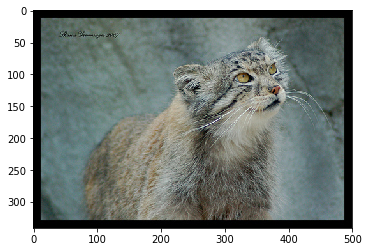

In [17]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
x, img = load_image("2074431221_e062a9a16d.jpg", 300, 300)
#save_file("http://static.flickr.com/2221/2074431221_e062a9a16d.jpg")

plt.imshow(img)